In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 3- LandTrendr and CCDC 

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/3.1-LandTrendr.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/3.1-LandTrendr.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/3.1-LandTrendr.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## 3.0: Overview and Introduction

### LandTrendr
LandTrendr, short for Landsat-based detection of Trends in Disturbance and Recovery, is a temporal segmentation algorithm used for change detection as well as time-series smoothing. You can use LandTrendr outputs for stand-alone change detection or as inputs to modeling models such as the ones used by LCMS. 

#### Learn more about LandTrendr:
- [LandTrendr Guide](https://emapr.github.io/LT-GEE/)
- [LandTrendr Original Publication](https://www.sciencedirect.com/science/article/abs/pii/S0034425710002245)
- [LandTrendr GEE Publication](https://www.mdpi.com/2072-4292/10/5/691)

### CCDC
CCDC stands for Continuous Change Detection and Classification. CCDC has a fundamentally different definition of what "change" is from LandTrendr. LandTrendr defines change as a difference in the linear direction of the time series as depicted with a linear regression model, while CCDC defines change as a difference in the seasonlity (phenology) as depicted using harmonic regression (linear regression over many different wave forms). 

<div class="alert alert-block alert-warning">
<b>Comment AP:</b> I changed a few words in the CCDC section because saying "defines change as a change..." can be a little confusing. I replaced with difference. 
</div>

As a result, in general, LandTrendr's depiction of change aligns with many forest-related change types such as fire, insects and disease, etc. While these types of changes often alter the direction of the trajectory abruptly, they do not always change the seasonlity patterns in an abrupt manner. 

CCDC can be better at detection detecting changes that merely impact the phenology that LandTrendr can miss. This can be useful in agricultural and rangeland applications.

#### Learn more about CCDC:
- [Zhu and Woodock 2014: Original CCDC Publication](https://www.sciencedirect.com/science/article/abs/pii/S0034425714000248)
- [GEE CCDC Documentation](https://developers.google.com/earth-engine/apidocs/ee-algorithms-temporalsegmentation-ccdc)
- [Arevalo et al. 2020: A Suite of Tools for Continuous Land Change Monitoring in Google Earth Engine](https://www.frontiersin.org/articles/10.3389/fclim.2020.576740/full)
- [Cloud-Based Remote Sensing with Google Earth Engine](https://www.eefabook.org/) Chapter 4.6: [Interpreting Time Series with CCDC](https://docs.google.com/document/d/11oo1TuvXyEvReoYLDeTcoh16rEN90I8Bf5qp0KxVu7U/edit#heading=h.s893qtc8bydw)

<div class="alert alert-block alert-warning">
<b>Comment AP:</b> Cannot access Chapter 4.6
</div>
**This notebook uses Landsat and Sentinel-2 composites, like the ones you created in the previous notebook, as inputs to the LandTrendr and CCDC temporal segmentation and spectral smoothing operations.**

### 3.0.1: Objective

In this tutorial, you learn how to create and manipulate LandTrendr outputs.

**This tutorial uses the following Google Cloud services:**

- Google Earth Engine

**The steps performed include:**

- Create LandTrendr outputs
- Manipulate EE array image objects to get meaningful data out of LandTrendr outputs
- Create tile mesh grid over a study area
- Create CCDC outputs over the mesh grid
- Manipulate EE array image objects to get meaningful data out of CCDC outputs for change detection

**Learning objectives include:**
- Users will understand the purpose of temporal segmentation as implemented in LandTrendr.
- Users will understand key parameters in LandTrendr algorithm. 
- Users will be able to generate and manipulate array outputs from LandTrendr. 
- Users will understand the purpose of temporal segmentation as implemented in CCDC.
- Users will understand key parameters in CCDC algorithm. 
- Users will be able to generate and manipulate array outputs from CCDC. 


### 3.0.2: Before you begin

#### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

#### Optional: Set a folder to use for all exports under `export_path_root` 
**If you accessed this lab through Google Qwiklabs, do not change `export_path_root`.**
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the 'pre-baked folder'-- a directory where the outputs have already been created. 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/someFolder`. Use the projectID associated with your account.
* This folder does not have to already exist. If it does not exist, it will be created

In [2]:
workbench_url = 'https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = 'projects/qwiklabs-gcp-00-49f2ddcdfa8a/assets/train-me'
print('Done')

Done


#### Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing the `geeViz.changeDetectionLib as changeDetectionLib`. We will use this library later to deploy the LandTrendr functions.

In [3]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p

import inspect

ee = getImagesLib.ee
Map = getImagesLib.Map

print('Done')

Initializing GEE
Successfully initialized
geeViz package folder: /opt/conda/lib/python3.10/site-packages/geeViz
Done


#### Set up your work environment

Specify an image collection path where composites were exported to. In addition, create a blank image collection where your LandTrendr outputs will be exported to.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [4]:
# Create folder and a collection and make public

export_composite_collection = f'{export_path_root}/lcms-training_module-2_composites'
export_landTrendr_collection = f'{export_path_root}/lcms-training_module-3_landTrendr'

aml.create_asset(export_landTrendr_collection,asset_type = ee.data.ASSET_TYPE_IMAGE_COLL)

# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_landTrendr_collection,writers = [],all_users_can_read = True,readers = [])

print('Done')

Found the following sub directories:  ['train-me', 'lcms-training_module-3_landTrendr']
Will attempt to create them if they do not exist
Asset projects/qwiklabs-gcp-00-49f2ddcdfa8a/assets/train-me already exists
Asset projects/qwiklabs-gcp-00-49f2ddcdfa8a/assets/train-me/lcms-training_module-3_landTrendr already exists
Updating permissions for:  projects/qwiklabs-gcp-00-49f2ddcdfa8a/assets/train-me/lcms-training_module-3_landTrendr
Done


#### Set up the map 

Run the code block below to set up the map. If, you notice that the map is still displaying outputs from a previous lab, you may need to re-run this code block to reset the port used for the proxy URL. 

In [5]:
# Set up the map

Map.clearMap()
Map.port = 1234 # reset port if necessary
Map.proxy_url = workbench_url

## 3.2: Change detection with LandTrendr

LandTrendr is a temporal segmentation algorithm. LandTrendr works by taking a time series of annual values and fitting multiple linear regression models to recursively break the time series into segments that represent time periods with similar linear trends. The resulting segments can be used to describe change processes on the landscape. 

![landtrendr1](https://emapr.github.io/LT-GEE/imgs/segmentation.png)

By having the duration, magnitude, slope, etc of each segment, you can more easily detect change with simple rulesets.

![landtrendr2](https://emapr.github.io/LT-GEE/imgs/segment_attributes.png)

For example, a short, steep decline is likely to be a fast change, like harvest or fire. A long, shallow decline is likely to be a slower change, due to insects, disease, or drought. LandTrendr can also track periods of recovery, like a long shallow incline following a harvest or fire event. 

**For more information on LandTrendr, read [Chapter 4.5: Interpreting Annual Time Series with LandTrendr](https://docs.google.com/document/d/11oo1TuvXyEvReoYLDeTcoh16rEN90I8Bf5qp0KxVu7U/edit#heading=h.a480u2bjy8ur) in the [Cloud-Based Remote Sensing with Google Earth Engine ebook](https://www.eefabook.org/).**

<div class="alert alert-block alert-warning">
<b>Comment AP:</b> Cannot access Chapter 4.5
</div>


#### 3.2.1: LandTrendr bands and parameters

Look at the bands included in the **actual** collection that LCMS uses for LandTrendr in Puerto Rico. Note that the path to the asset refers to the LCMS Google Cloud Project. Load the image collection and print the names of the bands. 

In [6]:
lcms_actual_lt_collection = ee.ImageCollection('projects/lcms-292214/assets/R8/PR_USVI/Base-Learners/LandTrendr-Collection-1984-2020')
print('All bands LCMS uses for LandTrendr:',lcms_actual_lt_collection.aggregate_histogram('band').keys().getInfo())

All bands LCMS uses for LandTrendr: ['NBR', 'NDMI', 'NDSI', 'NDVI', 'blue', 'brightness', 'green', 'greenness', 'nir', 'red', 'swir1', 'swir2', 'tcAngleBG', 'wetness']


#### Composites

<p>For this lab, you'll </p>
<ol>
    <li>Load the composites that were computed in the previous lab </li>
    <li>Calculate fitted LandTrendr outputs that indicate the timing, duration, and magnitude of change-- among other outputs. </li>
</ol>
<p>Run the code block below. This code block will: </p>
<ul>
    <li>Inspect the composites that you're bringing in</li>
    <li>Get parameters from the composites that you will use as inputs to the LandTrendr algorithm </li>
    <li>Calculate additional indices that you will use in LandTrendr</li>
 </ul>

In [7]:
# Bring in composites and pull info from them
composites = ee.ImageCollection(export_composite_collection)

props = composites.first().toDictionary().getInfo()

startYear = props['startYear']
endYear = props['endYear']

startJulian = props['startJulian']
endJulian = props['endJulian']

proj = composites.first().projection().getInfo()

# Pull out the crs
# Depending on if a wkt or epsg format is used, it will be stored under a different key
if 'crs' not in proj.keys():
    crs = proj['wkt']
else:
    crs = proj['crs']
    
transform = proj['transform']
scale = None

studyArea = composites.first().geometry()

# Decompress composites by dividing by 10000 for optical bands and add indices
composites = composites.select(['blue','green','red','nir','swir1','swir2']).map(lambda img: img.divide(10000).float().copyProperties(img,['system:time_start']))
composites = composites.map(getImagesLib.simpleAddIndices)\
                      .map(getImagesLib.getTasseledCap)\
                      .map(getImagesLib.simpleAddTCAngles)


print('Done')

Done


#### Inspect
Now, inspect the composites. Run the code block below to add the composites to the map. 

You may need to click the button next to 'Composites' to view the layers on the map. Double-click the map to query the outputs. You should see a time series of values for each of the indices. 

In [8]:
# Run map
Map.clearMap()
Map.addTimeLapse(composites,getImagesLib.vizParamsFalse,'Composites')

Map.centerObject(studyArea,9)
Map.turnOnInspector()
Map.view()

Adding layer: Composites
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Starting local web server at: http://localhost:1234/geeView/
HTTP server command: "/opt/conda/bin/python" -m http.server  1234
Done
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


### 3.2.#: Running LandTrendr

### 3.2.#: Input bands and band indices

We can use any or all of the bands in the composites for LandTrendr, but generally bands or band indices that use the NIR and SWIR portions of the electromagnetic spectrum are the most useful. To start, we will be running LandTrendr on only band index: NBR.

#### LandTrendr parameters
The input parameters for the LandTrendr algorithm are described below. 

| Argument               | Type                    | Details                                                                                                                                                           |
|------------------------|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| timeSeries             | ImageCollection         | Yearly time-series from which to extract breakpoints. The first band is usedto find breakpoints, and all subsequent bands are fitted using those breakpoints.     |
| maxSegments            | Integer                 | Maximum number of segments to be fitted on the time series.                                                                                                       |
| spikeThreshold         | Float, default: 0.9     | Threshold for dampening the spikes (1.0 means no dampening).                                                                                                      |
| vertexCountOvershoot   | Integer, default: 3     | The initial model can overshoot the maxSegments + 1 vertices by this amount. Later, it will be pruned down to maxSegments + 1.                                    |
| preventOneYearRecovery | Boolean, default: False | Prevent segments that represent one year recoveries.                                                                                                              |
| recoveryThreshold      | Float, default: 0.25    | If a segment has a recovery rate faster than 1/recoveryThreshold (in years), then the segment is disallowed.                                                      |
| pvalThreshold          | Float, default: 0.1     | If the p-value of the fitted model exceeds this threshold, then the current model is discarded and another one is fitted using the Levenberg-Marquardt optimizer. |
| bestModelProportion    | Float, default: 0.75    | Allows models with more vertices to be chosen if their p-value is no more than (2 - bestModelProportion) times the p-value of the best model.                     |
| minObservationsNeeded  | Integer, default: 6     | Min observations needed to perform output fitting.                                                                                                                |

##### Parameter values
LCMS generally uses the default parameters for the GEE implementation of LandTrendr. Refer to the parameter values in the **GEE** column below. The table below is reproduced from [Kennedy et al. 2018](https://www.mdpi.com/2072-4292/10/5/691), which developed the GEE implementation of LandTrendr from the original IDL version. 

|       Parameter       |  IDL |   GEE   |                                                                                                        Comments                                                                                                       |
|:---------------------:|:----:|:-------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|      maxSegments      |   6  |    6    |                                                                                                                                                                                                                       |
|     spikeThreshold    |  0.9 |   0.9   | Renamed from “desawtooth val”                                                                                                                                                                                         |
|  vertexCountOvershoot |   3  |    3    |                                                                                                                                                                                                                       |
|   recoveryThreshold   | 0.25 |   0.25  |                                                                                                                                                                                                                       |
|     pvalThreshold     | 0.05 |   0.05  |                                                                                                                                                                                                                       |
|  bestModelProportion  | 0.75 |   0.75  |                                                                                                                                                                                                                       |
| minObservationsNeeded |   6  |    6    | Renamed from “minneeded”                                                                                                                                                                                              |
|     Background_val    |   0  |    NA   | GEE uses a mask logic to avoid missing values caused by clouds, shadows, and missing imagery.                                                                                                                         |
|        Divisor        |  −1  |    NA   | Ensures that vegetation loss disturbance results in negative change in value when NBR is used as a spectral metric. In GEE, this must be handled outside of the segmentation algorithm.                               |
|       Kernelsize      |   1  | Dropped | Originally used together with skipfactor to save computational burden; no longer necessary.                                                                                                                           |
|       Skipfactor      |   1  | Dropped |                                                                                                                                                                                                                       |
|    Distweightfactor   |   2  | Dropped | Inadvertently hardwired in the IDL code, this parameter was hardwired in the GEE code to the value of 2.                                                                                                              |
|     Fix_doy_effect    |   1  | Dropped | Although correcting day-of-year trends was considered theoretically useful in the original LT implementation, in practice it has been found to distort time series values when change occurs and thus was eliminated. |

**Run the code block below to set the parameters.**

In [9]:
#Define landtrendr params
run_params = { 
  'maxSegments':            6,
  'spikeThreshold':         0.9,
  'vertexCountOvershoot':   3,
  'preventOneYearRecovery': False,
  'recoveryThreshold':      0.25,
  'pvalThreshold':          0.05,
  'bestModelProportion':    0.75,
  'minObservationsNeeded':  6
}

print('Done')

Done


### 3.2.#: Run LandTrendr - single index
You will start by running LandTrendr on a single index in order to familiarize yourself with the process and the outputs. 

Run LandTrendr using [Normalized Burn Ratio](https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio) (NBR).  NBR is a ratio between the NIR and SWIR bands, and is sensitive to changes in moisture and vegetation cover. This will allow you to inspect changes on the landscape without requiring the computation time necessary for all of the bands and band indices in our composite.



In [10]:
# clear map
Map.clearMap()

# set up LandTrendr
test_band = 'NBR'
run_params['timeSeries'] = composites.select([test_band])
raw_LT = ee.Algorithms.TemporalSegmentation.LandTrendr(**run_params)

# Add to Map
Map.addLayer(raw_LT,{},'LT Raw {}'.format(test_band),True)

Map.turnOnInspector()
Map.view()

Adding layer: LT Raw NBR
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Starting local web server at: http://localhost:1234/geeView/
HTTP server command: "/opt/conda/bin/python" -m http.server  1234
Done
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


Double click on the output on the map to query it. 

Notice that this output is not immediately useful for change detection, or smoothing out a time series of composites. The default output is in array format, and has to be processed more in order for us to apply meaningful symbology on the map.


#### Use LandTrendr for Change Detection
Using the outputs you just generated, you will now go through each step to take the raw LandTrendr output and create a basic change detection output.

At each step, you will view the results at a single pixel in order to inspect the changes on the array of outputs that you are manipulating. 

#### Inspect raw LandTrendr outputs

Run the code block below to inspect the raw LandTrendr outputs.

In [11]:
# Provide an example location 
pt = ee.Geometry.Point([ -65.944 , 18.404])

# First, select the LandTrendr image array output band
lt_array = raw_LT.select(['LandTrendr'])

# Display output
display(g2p.imageArrayPixelToDataFrame(lt_array, pt,None,crs,transform, 'Raw LandTrendr Output - Single Pixel',\
                                       ['Years','Raw Input Values','Fitted Output Values','Vertex/non-vertex']))

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/http/server.py", line 1307, in <module>
    test(
  File "/opt/conda/lib/python3.10/http/server.py", line 1258, in test
    with ServerClass(addr, HandlerClass) as httpd:
  File "/opt/conda/lib/python3.10/socketserver.py", line 452, in __init__
    self.server_bind()
  File "/opt/conda/lib/python3.10/http/server.py", line 1301, in server_bind
    return super().server_bind()
  File "/opt/conda/lib/python3.10/http/server.py", line 137, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 466, in server_bind
    self.socket.bind(self.server_address)
OSError: [Errno 98] Address already in use


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Years,1984.000000,1985.000000,1986.000000,1987.000000,1988.000000,1989.000000,1990.000000,1992.000000,1999.000000,2000.000000,2002.000000,2003.000000,2006.000000,2009.000000,2010.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000
Raw Input Values,0.732861,0.567021,0.772094,0.716129,0.765138,0.656260,0.674274,0.714593,0.100228,0.086324,0.098278,0.035483,0.148884,0.076102,0.068394,0.125019,0.277041,0.380944,0.452543,0.547757,0.615267,0.552308,0.558119,0.336950,0.426205,0.430944
Fitted Output Values,0.759414,0.730053,0.700691,0.671330,0.641969,0.612607,0.583246,0.524523,0.318994,0.289633,0.230910,0.201549,0.113465,0.025381,-0.003980,-0.062703,0.111118,0.284938,0.458759,0.632580,0.589873,0.547167,0.504460,0.461754,0.419048,0.376341
Vertex/non-vertex,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


This is the raw output from the LandTrendr algorithm. The array has 2 dimensions per pixel.

The rows correspond to:
- Years
- Raw input spectral values
- LandTrendr fitted output values
- Whether or not that year represents a vertex

From this output, you can begin to understand the format of the outputs, why they aren't immediately interpretable on a map, and how you might begin to manipulate them into more meaningulf formats. 

## 3.3: Process LandTrendr outputs and Run on all bands

### 3.3.1: Array manipulation: Extract the vertices

The first step is to extract the vertices from the array. We only need the vertices at a pixel in order to track change-- we don't need the values for the interceding years.

Run the code block below to extract the vertices. You slice the array to extract the row indicating the vertices and use them as a mask to mask out non vertex values in the entire array.

In [12]:
# Slice the array to extract the row indicating the vertices
vertices = lt_array.arraySlice(0,3,4)
display(g2p.imageArrayPixelToDataFrame(vertices, pt, None,crs,transform,'Vertex mask row'))

# Use the vertex row as a mask to extract the values at the vertices
lt_array = lt_array.arrayMask(vertices)
display(g2p.imageArrayPixelToDataFrame(lt_array, pt, None,crs,transform,'Raw LandTrendr - Only Vertex Columns',\
                                                 ['Years','Raw Input Values','Fitted Output Values','Vertex/non-vertex']))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


127.0.0.1 - - [20/Sep/2023 18:25:43] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


,0,1,2,3
Years,1984.000000,2012.000000,2016.000000,2022.000000
Raw Input Values,0.732861,0.125019,0.547757,0.430944
Fitted Output Values,0.759414,-0.062703,0.632580,0.376341
Vertex/non-vertex,1.000000,1.000000,1.000000,1.000000


#### Calculate the difference between fitted vertex values
In order to perform change detection, you'll need to get the difference between fitted vertex values. 

You do this by slicing the array on an offset-- so that you can subtract adjacent values. 

Run the code block below to calculate the difference between the fitted vertex values. 

In [13]:
# In order to perform change detection, we'll need to get the difference between fitted vertex values
# We do this by slicing the first to the next to the last and then the second to the last and subtracting them
left = lt_array.arraySlice(1,0,-1)
right = lt_array.arraySlice(1,1,None)
diff  = left.subtract(right)

display(g2p.imageArrayPixelToDataFrame(left, pt, None,crs,transform,'Left Slice',\
                                       ['Years','Raw Input Values','Fitted Output Values','Vertex/non-vertex']))
display(g2p.imageArrayPixelToDataFrame(right, pt,None,crs,transform, \
                                       'Right Slice',['Years','Raw Input Values','Fitted Output Values','Vertex/non-vertex']))
display(g2p.imageArrayPixelToDataFrame(diff, pt, None,crs,transform,\
                                       'Left Minus Right',['Years','Raw Input Values','Fitted Output Values','Vertex/non-vertex']))

,0,1,2
Years,1984.000000,2012.000000,2016.000000
Raw Input Values,0.732861,0.125019,0.547757
Fitted Output Values,0.759414,-0.062703,0.632580
Vertex/non-vertex,1.000000,1.000000,1.000000


127.0.0.1 - - [20/Sep/2023 18:25:43] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


,0,1,2
Years,2012.000000,2016.000000,2022.000000
Raw Input Values,0.125019,0.547757,0.430944
Fitted Output Values,-0.062703,0.632580,0.376341
Vertex/non-vertex,1.000000,1.000000,1.000000


,0,1,2
Years,-28.000000,-4.000000,-6.000000
Raw Input Values,0.607841,-0.422738,0.116814
Fitted Output Values,0.822117,-0.695283,0.256238
Vertex/non-vertex,0.000000,0.000000,0.000000


#### Combine difference values with years
You then slice the right-hand years and the fitted vertex values difference and combine them.

Run the code block below to create an array that has a value for each vertex year and magnitude of difference. 

In [14]:
# Slice right-hand years and difference values
years = right.arraySlice(0,0,1)
mag = diff.arraySlice(0,2,3)
display(g2p.imageArrayPixelToDataFrame(years, pt, None,crs,transform,'Years'))
display(g2p.imageArrayPixelToDataFrame(mag, pt, None,crs,transform,'Magnitude'))

# Combine
forSorting = years.arrayCat(mag,0)
display(g2p.imageArrayPixelToDataFrame(forSorting, pt, None,crs,transform,'Year + Magnitude Array'))

,0,1,2
0,2012,2016,2022


,0,1,2
0,0.822117,-0.695283,0.256238


,0,1,2
0,2012.000000,2016.000000,2022.000000
1,0.822117,-0.695283,0.256238


#### Sort array based on change of interest

We can then sort this array to display the change we are most interested in. For example, we can extract the highest magnitude change, the most recent change, etc. 

In the example below, the sort row will be the magnitude. Thus, the output will be the highest severity change.


In [15]:
# Sort on magnitude
sorted = forSorting.arraySort(forSorting.arraySlice(0,1,2))
display(g2p.imageArrayPixelToDataFrame(sorted, pt, None,crs,transform,'Array Sorted by the Second Row (magnitude of change)'))

# Slice off the year and magnitude of the highest magnitude change
highest_mag_change_array = sorted.arraySlice(1,0,1)
display(g2p.imageArrayPixelToDataFrame(highest_mag_change_array, pt, None,crs,transform,'Highest Mag Change (year and magnitude)'))

,0,1,2
0,2016.000000,2022.000000,2012.000000
1,-0.695283,0.256238,0.822117


,0
0,2016.000000
1,-0.695283


#### Convert arrays into images

The final step is to convert the array output into an image. You've seen how array manipulation works on one pixel. You can now "flatten" the two-dimensional array into a one-dimensional image. 

Applying a change threshold allows you to determine what severity of change is flagged as loss. All change that is lower than this magnitude will be masked from the map. 

Run the code block below to flatten the array into an image and add it to the map. 

In [16]:
# First, choose a change threshold
# Any changes more negative than this value will be flagged as loss
change_threshold = -0.15

# Convert the sorted array image into a 2-band image
highest_mag_change = highest_mag_change_array.arrayProject([0]).arrayFlatten([['yr','mag']])

# Mask out any change 
highest_mag_change = highest_mag_change.updateMask(highest_mag_change.select(['mag']).lte(change_threshold))

# Pull the loss magnitude palette and flip the color order
lossMagPalette = changeDetectionLib.lossMagPalette.split(',')
lossMagPalette.reverse()

# Set up map
Map.clearMap()
Map.addLayer(forSorting,{},'Array for Sorting',False)
Map.addLayer(sorted,{},'Sorted Array',False)
Map.addLayer(highest_mag_change.select(['mag']),{'min':-0.8,'max':-0.15,'palette':lossMagPalette},'Loss Magnitude')
Map.addLayer(highest_mag_change.select(['yr']),{'min':startYear,'max':endYear,'palette':changeDetectionLib.lossYearPalette},'Loss Year')
Map.turnOnInspector()
Map.view()

Adding layer: Array for Sorting
Adding layer: Sorted Array
Adding layer: Loss Magnitude
Adding layer: Loss Year
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


#### Inspect the output
View the output on the map. Turn the layers off and on to view the Loss Year and Loss Magnitude rasters. Double click on a pixel to query it, and see the original array values to understand how they correspond to the end output. 

### 3.3.2: Run LandTrendr - on all bands

Now that you understand LandTrendr parameters and outputs, the next step is to run LandTrendr on all bands. This is a more realistic output. After some additional processing, you will use this output with the LCMS model in Modules 4 and 5. 

Note that the code below is the same as the code you used to run LandTrendr over a single band. But here, you are applying LandTrendr over each band, and you are not displaying the outputs of the array manipulation at each step. 

Run the code block below to compute and export LandTrendr output arrays for each of the bands listed in `bandNames`. 

In [17]:
# We will run LandTrendr for each band
#Clear the map in case it has been populated with layers/commands earlier
Map.clearMap()

# We can use any/all of the bands, but generally bands that use nir and swir are most useful
bandNames = ['red','nir','swir1','swir2','NBR','NDVI','brightness','greenness','wetness']

#Run LANDTRENDR
for bandName in bandNames:

    # Select the band and run LandTrendr
    run_params['timeSeries'] = composites.select([bandName])
    rawLT = ee.Algorithms.TemporalSegmentation.LandTrendr(**run_params)

    Map.addLayer(rawLT,{},'LT Raw {}'.format(bandName),False)

    # Notice the raw LandTrendr output is in GEE's image array format
    # We'll need to manipulate the raw output a bit to save on storage space

    # Mask out non vertex values to use less storage space
    ltArray = rawLT.select(['LandTrendr'])
    rmse = rawLT.select(['rmse'])
    vertices = ltArray.arraySlice(0,3,4)
    ltArray = ltArray.arrayMask(vertices)

    # Mask out all but the year and vertex fited values (get rid of the raw and vertex rows)
    ltArray = ltArray.arrayMask(ee.Image(ee.Array([[1],[0],[1],[0]])))
    rawLTForExport=ltArray.addBands(rmse)
    Map.addLayer(rawLTForExport,{},'LT Vertex Values Only {}'.format(bandName),False)

    # Show how the compressed vertex-only values can be decompressed later
    decompressedC = changeDetectionLib.simpleLTFit(ltArray,startYear,endYear,bandName,True,run_params['maxSegments'])
    Map.addLayer(decompressedC,{'bands':'{}_LT_fitted'.format(bandName),'min':0.2,'max':0.8},'Decompressed LT Output {}'.format(bandName),False)

    # Join the raw and fitted values
    fitted = decompressedC.select(['{}_LT_fitted'.format(bandName)])
    ltJoined = getImagesLib.joinCollections(composites.select([bandName]),fitted)
    Map.addLayer(ltJoined,{'bands':'{}_LT_fitted'.format(bandName),'min':0.2,'max':1,'palette':'D80,080'},'Raw and LT Fitted {}'.format(bandName),True)

    # Export LT array image
    # Set some properties that will be uses later
    rawLTForExport = rawLTForExport.set({'startYear':startYear,
                                          'endYear':endYear,
                                          'startJulian':startJulian,
                                          'endJulian':endJulian,
                                          'band':bandName})
    rawLTForExport =rawLTForExport.set(run_params)
    exportName = 'LT_Raw_{}_yrs{}-{}_jds{}-{}'.format(bandName,startYear,endYear,startJulian,endJulian)
    exportPath = export_landTrendr_collection + '/'+ exportName
    # Export output
    getImagesLib.exportToAssetWrapper(rawLTForExport,exportName,exportPath,{'.default':'sample'},studyArea,scale,crs,transform,overwrite=False)

Map.turnOnInspector()
Map.addLayer(studyArea, {'strokeColor': '0000FF'}, "Study Area", False)
Map.view()

Adding layer: LT Raw red
Adding layer: LT Vertex Values Only red
Adding layer: Decompressed LT Output red
Adding layer: Raw and LT Fitted red


127.0.0.1 - - [20/Sep/2023 18:25:45] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


LT_Raw_red_yrs1984-2022_jds152-151 currently exists or is being exported and overwrite = False. Set overwite = True if you would like to overwite any existing asset or asset exporting task
Adding layer: LT Raw nir
Adding layer: LT Vertex Values Only nir
Adding layer: Decompressed LT Output nir
Adding layer: Raw and LT Fitted nir
LT_Raw_nir_yrs1984-2022_jds152-151 currently exists or is being exported and overwrite = False. Set overwite = True if you would like to overwite any existing asset or asset exporting task
Adding layer: LT Raw swir1
Adding layer: LT Vertex Values Only swir1
Adding layer: Decompressed LT Output swir1
Adding layer: Raw and LT Fitted swir1
LT_Raw_swir1_yrs1984-2022_jds152-151 currently exists or is being exported and overwrite = False. Set overwite = True if you would like to overwite any existing asset or asset exporting task
Adding layer: LT Raw swir2
Adding layer: LT Vertex Values Only swir2
Adding layer: Decompressed LT Output swir2
Adding layer: Raw and LT Fi

If you'd like to track the status of export tasks, use the code below. 

In [18]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(export_landTrendr_collection, type = 'imageCollection')

print('done')

done


> Note: The geeViz library also provides wrapper functions for array processing and running LandTrendr. You can use the [`changeDetectionLib.convertToLossGain()`](https://github.com/gee-community/geeViz/blob/fdd8f0080301f8d915214b6e2d50af03a0915777/changeDetectionLib.py#L778C5-L778C22) function in the geeViz library to perform array processing. You can also use the [`changeDetectionLib.simpleLANDTRENDR`](https://github.com/gee-community/geeViz/blob/27a0c5d8a0a9c9623e67599bf06448d64b481c56/changeDetectionLib.py#L344) to run LandTrendr. Check out examples and documentation in the [geeViz/examples](https://github.com/gee-community/geeViz/blob/master/examples/LANDTRENDRViz.py) repository.





#### Convert LandTrendr array into time series - for input into LCMS

While we can use the LandTrendr output for change detection, LCMS uses it as inputs to change detection, land cover, and land use models. Next, you will convert the raw LandTrendr array image asset into a time series of annual fitted, segment duration, segment magnitude of change, and slope values.

This processing relies on the [`changeDetectionLib.batchSimpleLTFit`](https://github.com/gee-community/geeViz/blob/fdd8f0080301f8d915214b6e2d50af03a0915777/changeDetectionLib.py#L565) function. This function converts stacked outputs into a collection of fitted, annual outputs: e.g., magnitude of change, slope of change, duration of change for each year.

While the fitted LandTrendr value is generally of most importance to our models, LandTrendr segment duration, slope, and magnitude of change can also help our models.

Run the code block below to extract the fitted annual outputs and view them on the map.

In [19]:
# Load raw LandTrendr outputs
lt_asset = ee.ImageCollection(f'{pre_baked_path_root}/lcms-training_module-3_landTrendr')

# Convert into fitted, annual outputs: e.g., magnitude of change, slope of change, duration of change for each year
lt_fit = changeDetectionLib.batchSimpleLTFit(lt_asset,startYear,endYear,None,bandPropertyName='band',arrayMode=True)

#Add to the map
Map.clearMap()
Map.addLayer(lt_fit,{'bands':'swir2_LT_fitted,nir_LT_fitted,red_LT_fitted','min':0.15,'max':0.6},'LandTrendr All Predictors Time Series')


Map.turnOnInspector()
Map.addLayer(studyArea, {'strokeColor': '0000FF'}, "Study Area", False)
Map.view()

Adding layer: LandTrendr All Predictors Time Series
Adding layer: Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


#### Inspect
Double-click the map to query values and see actual and fitted values for indices over time. Vizualize image collection that is used as predictors in LCMS models. When you double-click the output on the map, notice the different values available to the models

#### Example: LandTrendr reduces noise in original composite time series 

The best way of understanding how LandTrendr contributes to reducing noise in the original composite time series is to visualize the LandTrendr outputs and the composite side-by-side. 

The below example takes the fitted values from LandTrendr and shows them along with the original composites. Notice many holes are now filled in by LandTrendr. In general, LandTrendr reduces the amount of noise in the time series. There is a risk, however, of fitting too much and omitting changes such as those seen in 2017 for Hurricane Maria.

Run the code block below to compare the fitted time series against the input composites. 

Click on the map, inspect the fitted time series, and watch the composite timelapse and the Landtrendr timelapse.

In [20]:
# Visualize fitted landTrendr composites
fitted_bns = lt_fit.select(['.*_fitted']).first().bandNames()
out_bns = fitted_bns.map(lambda bn: ee.String(bn).split('_').get(0))

# Give same names as composites
lt_synth = lt_fit.select(fitted_bns,out_bns)

# Clear Map
Map.clearMap()

# Visualize raw and LandTrendr fitted composites
Map.addTimeLapse(composites,getImagesLib.vizParamsFalse,'Raw Composite Timelapse')
Map.addTimeLapse(lt_synth,getImagesLib.vizParamsFalse,'Fitted LandTrendr Composite Timelapse')

# Join the raw and fitted values
ltJoined = getImagesLib.joinCollections(composites.select(bandNames),lt_fit.select(['.*_fitted']))

# Add to Map
Map.addLayer(ltJoined,{'min':0.2,'max':1},'Raw and LT Fitted',True)

Map.turnOnInspector()
Map.addLayer(studyArea, {'strokeColor': '0000FF'}, "Study Area", False)
Map.view()

Adding layer: Raw Composite Timelapse
Adding layer: Fitted LandTrendr Composite Timelapse
Adding layer: Raw and LT Fitted
Adding layer: Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [20/Sep/2023 18:25:51] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


### Lab 3 Challenge 1: 

Calculate LandTrendr stats for NDVI and process arrays into most recent change year.

**For Qwiklabs users**, this will be assessed for completion in the Activity Tracking portion of Module 3.

<div class="alert alert-block alert-danger">
<b>Code Below:</b> Add challenge code
</div>

In [21]:
# Insert challenge code here

### Congratulations! You're done with the LandTrendr portion of Lab 3

Other GeeViz LandTrendr examples: 
- https://github.com/redcastle-resources/geeViz/blob/master/examples/LANDTRENDRViz.py
- https://github.com/redcastle-resources/geeViz/blob/master/examples/LANDTRENDRWrapper.py
- https://github.com/redcastle-resources/geeViz/blob/master/examples/LANDTRENDRWrapperNotebook.ipynb


LandTrendr fitted data will be used as inputs to LCMS in subsequent modules.

## 3.4: Scaling over large areas: memory concerns

CCDC is the most memory intensive algorithm used in LCMS. As a result, you are the most likely to need to use tile scaling or another memory management approach when running CCDC, particularly over large study areas.

You will generally only use tiles when a process fails due to memory or internal errors. Then, you will divide the study area up into tiles. You should you the maximum tile size that allows your process to complete with no errors.

### 3.4.1: View tiles used in current CONUS LCMS workflow

Currently, we run LCMS for the Continental US (CONUS), Coastal Alaska, Hawaii, and Puerto Rico / the US Virgin Islands. For CONUS, we have to divide all processing up in order to avoid running out of memory.

Note that the tiles below are much larger than Puerto Rico and the US Virgin Islands. You do not strictly need to create tiles to run CCDC in Puerto Rico, but we provide this example of scaling so that you can apply it if you work on other study areas. 

This next block of code will show the tiles that the LCMS composites use for exporting to asset.

In [22]:
# First, view the tiles used in the current CONUS LCMS workflow
lcms_CONUS_composites = ee.ImageCollection('projects/lcms-tcc-shared/assets/Composites/Composite-Collection-yesL7-1984-2020')\
                                                .filter(ee.Filter.calendarRange(2022,2022,'year'))

# Pull the geometry of each tile in the composites
lcms_composites_tile_geo = lcms_CONUS_composites.map(lambda f:ee.Feature(f.geometry()).copyProperties(f,['studyAreaName']))

# Add the tiles and a composite for reference
Map.clearMap()
Map.addLayer(lcms_CONUS_composites.mosaic(),getImagesLib.vizParamsTrue10k,'Example CONUS 2022 LCMS Composite')
Map.addLayer(lcms_composites_tile_geo,{},'LCMS Composite Tile Geometry')

Map.centerObject(lcms_composites_tile_geo)
Map.turnOnInspector()
Map.view()

127.0.0.1 - - [20/Sep/2023 18:25:51] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


Adding layer: Example CONUS 2022 LCMS Composite
Adding layer: LCMS Composite Tile Geometry
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


### 3.4.2: Create tiles of various sizes

**To determine what size tile you would use:** Generally, you would start with the biggest tile possible and work your way down till you stop having memory issues. Currently, LCMS uses 480km tiles (with a 900m buffer) for most processing (everything but CCDC)

To determine what size tile to use for your project, you can create and inspect tiles of various sizes. Below is an example of how to create a pyramid of tiles at various scales.

Run the code block below to generate a set of tile grids of various sizes across the Continental US. Turn the layers on and off to compare the size of the grids. 

In [23]:
Map.clearMap()

# set study area and projection
lcms_CONUS_studyArea = ee.FeatureCollection('projects/lcms-292214/assets/CONUS-Ancillary-Data/conus')
lcms_CONUS_projection = lcms_CONUS_composites.first().projection()

# get grid and add to map
def getGrid(studyArea,projection,size):
  grid = studyArea.geometry().coveringGrid(projection.atScale(size))
  Map.addLayer(grid,{},'Tile Grid {}m'.format(size))
  return grid

# get grids
grid480= getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,480000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,240000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,120000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,60000)

# add to Map
Map.addLayer(lcms_CONUS_studyArea,{},'LCMS CONUS Study Area')

Map.turnOnInspector()
Map.view()


Adding layer: Tile Grid 480000m
Adding layer: Tile Grid 240000m
Adding layer: Tile Grid 120000m
Adding layer: Tile Grid 60000m
Adding layer: LCMS CONUS Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


#### Takeaway from this map
You can scale in all different sizes, but best practice to explore different tile sizes is to pyramid the tiles by dividing the size by 2 for each smaller size. The scale of tile you choose for your operation will depend on your study area and the process you want to perform. Tiles might be too large or too small for area of interest depending on the size of the area and the complexity of the process being performed.

### How to use tiles to scale over large areas
To use tiles in practice, you first need to create a list of each available tile. Then, you will iterate your function of interest across each tile, clip it to the study area, buffer it, get the data, and export.

Run the code below to examine the first two tiles used for LCMS in the Continental US. The CCDC script would run over each of these tiles one at a time and then mosaic the results together to create the output over the large geographic area of the US. 

In [24]:
Map.clearMap()

ids = grid480.limit(2).aggregate_histogram('system:index').keys().getInfo()
for id in ids:
  # Get the tile and clip it to the study area and then buffer
  tile = grid480.filter(ee.Filter.eq('system:index',id)).geometry().intersection(lcms_CONUS_studyArea,240,lcms_CONUS_projection).buffer(900)
  Map.addLayer(tile,{},'Tile {}'.format(id))

Map.centerObject(tile)
Map.view()

127.0.0.1 - - [20/Sep/2023 18:25:52] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Sep/2023 18:25:52] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Sep/2023 18:25:52] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


Adding layer: Tile -3,-6
Adding layer: Tile -4,-6
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


## 3.5: CCDC

CCDC has a fundamentally different definition of what "change" is from LandTrendr. LandTrendr defines change as a change in the linear direction of the time series as depicted with a linear regression model, while CCDC defines change as a change in the seasonlity (phenology) as depicted using harmonic regression (linear regression over many different wave forms). 

As a result, in general, LandTrendr's depiction of change aligns with many forest-related change types such as fire, insects and disease, etc. While these types of changes often change the direction of the trajectory abruptly, they do not always change the seasonlity patterns in an abrupt manner. 

CCDC can be better at detection detecting changes that merely impact the phenology that LandTrendr can miss. This can be useful in agricultural and rangeland applications.

<div class="alert alert-block alert-info">
<b>Comment LL:</b> ADD SOME EXAMPLE PICTURES OR FIGURES FROM AREVALO ET AL 2020
</div>

### 3.5.1: Running CCDC - one tile

#### Set up tiles 

We'll use the full Puerto Rico and US Virgin Islands LCMS study area, and will run our analysis from 1984-2023.

Run the code block below to set up the scale of tiles, study area, projection, and tile grid. You will add the tile grid and the study area to the map

In [25]:
# Set the size (in meters) of the tiles
tileSize = 60000

# Specify study area
studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')

# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)


# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))

# clear the map
Map.clearMap()

# Add to map
Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))
Map.addLayer(studyArea,{},'Study Area')

Map.turnOnInspector()
Map.centerObject(studyArea)
Map.view()

Adding layer: Tile Grid 60000m
Adding layer: Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


### 3.5.2: Get Landsat imagery 

Next, set some preliminary parameters that describe the Landsat imagery you'll bring in to the CCDC Analysis. 

The parameters below you should seem familiar from module 2. However, for this module, we'll be pulling in a continuous series of imagery to which you'll apply a cloud mask-- rather than creating annual composites. This is because CCDC takes a continuous, interannual series of clear observations, as opposed to LandTrendr, which takes annual composites. 

Refer to the documentation for [`getImagesLib.getProcessedLandsatScenes`](https://github.com/gee-community/geeViz/blob/27a0c5d8a0a9c9623e67599bf06448d64b481c56/getImagesLib.py#L2563) for more details.

#### Select study area

We'll start with one tile in the Puerto Rico and US Virgin Islands LCMS study area. We'll use the tile that falls over El Yunque National Forest, but any smaller subset should work. 

#### Select date range

More than a 3 year span should be provided for time series methods to work well. If providing pre-computed stats for cloudScore and TDOM, this does not matter. Here, you will run your analysis from 1984-2023.

You will update the startJulian and endJulian variables to indicate your seasonal constraints. This supports wrapping for tropics and southern hemisphere. If using wrapping and the majority of the days occur in the second year, the system:time_start will default to June 1 of that year. Otherwise, all system:time_starts will default to June 1 of the given year.

#### Select bands and indices to obtain

You will also determine which bands/indices to obtain to run the CCDC analysis. These will not always be used to find breaks - that is specified below in the `breakpointBands` parameter for CCDC. 

Be sure that any bands in `ccdcParams.breakpointBands` parameter, which we'll set next, are in this list.

Options for bands are: "blue","green","red","nir","swir1","swir2","NDVI","NBR","NDMI","NDSI","brightness","greenness","wetness","fourth","fifth","sixth","tcAngleBG"

#### Remove high values for bands and indices
You will also write a function to remove any high value for bands or indices. These high values might be artifacts and result in errors, so we'll remove them from the time series. You'll apply the function to the image.

* Run the code block below to obtain and process Landsat imagery.


In [26]:
# list tile ids
ids = grid.aggregate_histogram('system:index').keys().getInfo()

# Get the tile and buffer it so there are no missing pixels at tile edges
tile = grid.filter(ee.Filter.eq('system:index',ids[6]))

#Specify start and end years for all analyses
startYear = 1984
endYear = 2023

#startJulian: Starting Julian date
#endJulian: Ending Julian date
startJulian = 1
endJulian = 365

#Choose whether to include Landat 7
#Generally only included when data are limited
includeSLCOffL7 = True

# set export bands
exportBands = ["blue","green","red","nir","swir1","swir2","NDVI"]

# Write function to Remove any extremely high band/index values
def removeGT1(img):
  lte1 = img.select(['blue','green','nir','swir1','swir2']).lte(1).reduce(ee.Reducer.min());
  return img.updateMask(lte1);

# set viz params
getImagesLib.vizParamsFalse['min']=0.15
getImagesLib.vizParamsFalse['max']=0.8

# get processed scenes
processedScenes = getImagesLib.getProcessedLandsatScenes(studyArea = tile, startYear = startYear, endYear = endYear,
                                                    startJulian = startJulian,endJulian = endJulian,
                                                   includeSLCOffL7 = includeSLCOffL7).select(exportBands)

# apply function to remove high band/index values
processedScenes = processedScenes.map(removeGT1)

# print(processedScenes.size().getInfo())
print('Done')

# add to map
Map.clearMap()
Map.addLayer(tile,{},'Tile {}'.format(id))
Map.centerObject(tile)

#Map.addLayer(processedScenes,getImagesLib.vizParamsFalse,'Raw Processed Landsat Input')
Map.addLayer(processedScenes,{}, 'Processed Landsat Input')


Map.turnOnInspector()
Map.view()

Get Processed Landsat: 
Start date: Jan 01 1984 , End date: Dec 31 2023
Applying scale factors for C2 L4 data
Applying scale factors for C2 L5 data
Applying scale factors for C2 L8 data
Including All Landsat 7
Applying scale factors for C2 L7 data
Applying scale factors for C2 L9 data
Applying Fmask Cloud Mask
Applying Fmask Shadow Mask
Done
Adding layer: Tile -4,-6
Adding layer: Processed Landsat Input
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


### 3.5.3: Set CCDC parameters

Next, you'll set the parameters that will be used in the CCDC algorithm. The parameters are described below. For more information, refer to the [GEE CCDC Documentation](https://developers.google.com/earth-engine/apidocs/ee-algorithms-temporalsegmentation-ccdc).

#### CCDC parameters

**CCDC Parameters include:**
| Argument             | Type                    | Details                                                                                                                                                                                                                                |
|----------------------|-------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| collection           | ImageCollection         | Collection of images on which to run CCDC.                                                                                                                                                                                             |
| breakpointBands      | List, default: None     | The name or index of the bands to use for change detection. If unspecified, all bands are used.                                                                                                                                        |
| tmaskBands           | List, default: None     | The name or index of the bands to use for iterative TMask cloud detection. These are typically the green band and the SWIR1 band. If unspecified, TMask is not used. If specified, 'tmaskBands' must be included in 'breakpointBands'. |
| minObservations      | Integer, default: 6     | The number of observations required to flag a change.                                                                                                                                                                                  |
| chiSquareProbability | Float, default: 0.99    | The chi-square probability threshold for change detection in the range of [0, 1]                                                                                                                                                       |
| minNumOfYearsScaler  | Float, default: 1.33    | Factors of minimum number of years to apply new fitting.                                                                                                                                                                               |
| dateFormat           | Integer, default: 0     | The time representation to use during fitting: 0 = jDays, 1 = fractional years, 2 = unix time in milliseconds. The start, end and break times for each temporal segment will be encoded this way.                                      |
| lambda               | Float, default: 20      | Lambda for LASSO regression fitting. If set to 0, regular OLS is used instead of LASSO. 20 would be if input data was scaled 0-10000. If 0-1 reflectance, 20 would become 0.002                                                                                                                                                |
| maxIterations        | Integer, default: 25000 | Maximum number of runs for LASSO regression convergence. If set to 0, regular OLS is used instead of LASSO.                                                                                                                            |
* Run the code chunk below to set the parameters that you'll use in the CCDC model.


In [27]:
# Set CCDC parameters
ccdcParams ={
  'breakpointBands':['green','red','nir','swir1','swir2','NDVI'],
  'tmaskBands' : None,
  'minObservations': 6,
  'chiSquareProbability': 0.99,
  'minNumOfYearsScaler': 1.33,
  'lambda': 0.002, # Since our reflectance data is 0-1 and not 0-10000, we divide 20 by 10000
  'maxIterations' : 25000,
  'dateFormat' : 1
}

print('Done')

Done


### 3.5.4 - Run CCDC algorithm

* Now, we'll iterate across one tile and run CCDC.
* You'll add the CCDC output to the map, with the Landsat data.
* Double-click on the outputs to see the values of the Landsat data and how they relate to the CCDC raw output. 
* You'll notice the raw CCDC output is even more complex than the LandTrendr output.

In [28]:
#Set the scene collection in the ccdcParams
ccdcParams['collection'] = processedScenes

#Run CCDC
ccdc = ee.Image(ee.Algorithms.TemporalSegmentation.Ccdc(**ccdcParams))

# add to Map
#Map.clearMap()
#Map.addLayer(processedScenes,{},'Raw Processed Landsat Input')
Map.addLayer(ccdc,{},'CCDC Output')

Map.turnOnInspector()
Map.view()

Adding layer: CCDC Output
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


#### Interpret CCDC outputs

In order to understand how CCDC outputs relate to the original input data, we will join the raw input NDVI values to the predicted NDVI values from CCDC.  

**Extracting the data can take some time, and querying this map will often yield errors as this process is quite computationally intensive. Please be patient.**

In [32]:
# Specify which bands to show in the example
exampleBandNames = ['NDVI']

# Now let's join the raw and predicted CCDC for a subset of time 
processedScenes = processedScenes\
                    .filter(ee.Filter.calendarRange(2010,2023,'year'))\
                    .map(getImagesLib.addYearYearFractionBand)

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

fitted = changeDetectionLib.predictCCDC(ccdc,processedScenes.select(['year']),fillGaps=fillGaps,whichHarmonics=[1,2,3])

exampleFittedBandNames = [f'{bn}_CCDC_fitted' for bn in exampleBandNames]

ccdcJoined = getImagesLib.joinCollections(processedScenes.select(exampleBandNames),fitted.select(exampleFittedBandNames))
ccdcJoinedBns = ccdcJoined.first().bandNames().getInfo()

# View the map
Map.clearMap()
Map.addLayer(ccdcJoined,{'min':0.2,'max':0.8},'Raw Landsat and CCDC Fitted')
Map.turnOnInspector()
Map.view()



Adding layer: Raw Landsat and CCDC Fitted
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [20/Sep/2023 20:33:26] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


#### View CCDC outputs at a single point

We'll extract a single pixel of the output to illustrate how the raw inputs relate to the fitted CCDC output.

Extracting raw Landsat and fitted CCDC values
Done


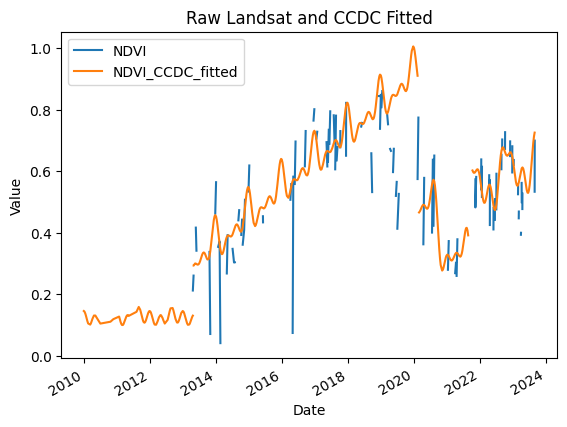

In [37]:
# # Provide an example location 
pt = ee.Geometry.Point([ -65.944 , 18.404])

# Extract the values and plot them
print('Extracting raw Landsat and fitted CCDC values')
timSeries = g2p.extractPointValuesToDataFrame(ccdcJoined,pt,scale=None,crs = crs, transform = transform)
timSeries['system:time_start']= g2p.pandas.to_datetime(timSeries['system:time_start'], unit='ms')

timSeriesT = timSeries[ccdcJoinedBns]
timSeriesT.index = timSeries['system:time_start']
timSeriesT.plot.line(title='Raw Landsat and CCDC Fitted',xlabel='Date',ylabel='Value')

print('Done')

#### Inspect

What do you notice about the raw NDVI calues and the CCDC values? How many segments are fitted? Remember that similar output is fitted for every single pixel in the image, for each of the bands you selected to include in the algorithm. 

### 3.5.5 - Run CCDC over all tiles
**Iterate across all tiles and export CCDC outputs**

Now that you understand how to run CCDC over Landsat data, you will run the same process over all of the tiles, and export the data as an asset. 

Run the code block below to iterate over the tile ids to obtain imagery, run the CCDC algorithm, and export the output.

<div class="alert alert-block alert-danger">
<b>Code below:</b> Traceback error on 'export_ccdc_collection' is not defined.
</div>


In [38]:
#iterate over ids
for id in ids:
    print(id)
    # Get the tile and buffer it so there are no missing pixels at tile edges
    tile = grid.filter(ee.Filter.eq('system:index',id)).geometry().intersection(studyArea,240,projection).buffer(900)
    
    # Map.addLayer(tile,{},'Tile {}'.format(id))
    
    processedScenes = getImagesLib.getProcessedLandsatScenes(studyArea = tile,startYear = startYear, endYear = endYear,
                                                        startJulian = startJulian,endJulian = endJulian,
                                                        includeSLCOffL7 = includeSLCOffL7).select(exportBands)
    processedScenes = processedScenes.map(removeGT1)
    # print(processedScenes.size().getInfo())
    
    #Set the scene collection in the ccdcParams
    ccdcParams['collection'] = processedScenes

    #Run CCDC
    ccdc = ee.Image(ee.Algorithms.TemporalSegmentation.Ccdc(**ccdcParams))
    ccdc = ccdc.set({'startYear':startYear,
                     'endYear':endYear,
                     'startJulian':startJulian,
                     'endJulian':endJulian,
                     'TileSize':tileSize,
                     'TileID':id})
    
    # Export the output
    exportName = 'CCDC_Tile-{}m_ID{}_yrs{}-{}_jds{}-{}'.format(tileSize,id.replace(',','-'),startYear,endYear,startJulian,endJulian)
    exportPath = f'{export_ccdc_collection}/{exportName}'
    print(exportPath)

    getImagesLib.exportToAssetWrapper(ccdc,exportName,exportPath,{'.default':'sample'},tile,scale,crs,transform,overwrite=False)
    
print('Done')

90,54
Get Processed Landsat: 
Start date: Jan 01 1984 , End date: Dec 31 2023
Applying scale factors for C2 L4 data
Applying scale factors for C2 L5 data
Applying scale factors for C2 L8 data
Including All Landsat 7
Applying scale factors for C2 L7 data
Applying scale factors for C2 L9 data
Applying Fmask Cloud Mask
Applying Fmask Shadow Mask


NameError: name 'export_ccdc_collection' is not defined

#### Task tracking and file management

You can track tasks in the code block below, or by visiting https://code.earthengine.google.com/tasks . 

Uncomment the commands below to track the tasks, if desired. This will report which tasks are in process, and their export status. 


In [33]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(exportPathRoot, type = 'imageCollection')

print('done')

0 tasks ready 2023-09-20 20:35:58
0 tasks running 2023-09-20 20:35:58
Running names:


done


#### Inspect outputs

Bring in the outputs and mosaic them into a single image. We will use this image later. 


In [34]:
Map.clearMap()

# Bring in the outputs and mosaic them into a single image
ccdcImg = ee.ImageCollection(f'{pre_baked_path_root}/lcms-training_module-3_CCDC').mosaic()
Map.addLayer(ccdcImg,{'addToLegend':False},'CCDC Raw Image')
Map.centerObject(studyArea,10)
Map.turnOnInspector()
Map.view()

Adding layer: CCDC Raw Image
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://683b3a99920a5e68-dot-us-central1.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [20/Sep/2023 20:36:14] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


Click on the map to query the outputs. You'll see that there are multi-band outputs that include coefficients, magnitude, and RMSE for all bands. Like the LandTrendr outputs, the array outputs are challenging to parse! We'll visualize the outputs in more detail a little later. 



### 3.5.6: Using CCDC to detect change

We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients.

#### Inspect CCDC image
First, inspect the properties of the CCDC image to understand what you'll be manipulating. 

In [35]:
## INSPECT PROPERTIES OF CCDCIMG 
print(ccdcImg.bandNames().getInfo())

['tStart', 'tEnd', 'tBreak', 'numObs', 'changeProb', 'blue_coefs', 'green_coefs', 'red_coefs', 'nir_coefs', 'swir1_coefs', 'swir2_coefs', 'NDVI_coefs', 'blue_rmse', 'green_rmse', 'red_rmse', 'nir_rmse', 'swir1_rmse', 'swir2_rmse', 'NDVI_rmse', 'blue_magnitude', 'green_magnitude', 'red_magnitude', 'nir_magnitude', 'swir1_magnitude', 'swir2_magnitude', 'NDVI_magnitude']


#### Inspect ccdcChange Detection function

Below, inspect the `ccdcChangeDetection` function in the `changeDetectionLib` to see what kind of parameters and inputs we'll need. 

Pay attention to:
<ol>
    <li> a) the objects / parameters that are input to the function and </li>
    <li> b) what the function returns</li>
 </ol>
 
 ol.d {
  list-style-type: lower-alpha;
}

In [ ]:
# print option
print(inspect.getsource(changeDetectionLib.ccdcChangeDetection))

#### Takeaways from the ccdcChangeDetection function
Note that the function returns an object that contains a dictionary with objects titled `mostRecent` and `highestMag`. These outputs are different methods of sorting the CCDC change information-- by most recent (`'mostRecent'`) or highest magnitude (`'highestMag'`) CCDC break.

### 3.5.7: Set change detection parameters for CCDC algorithm
This function allows us to manipulate CCDC outputs in array format in order to get meaningful information -- that is, information that's more directly useful than a modeled spectral trajectory. 

#### Specify band used for change detection

This is most important for the loss and gain magnitude since the year of change will be the same for all years

`changeDetectionBandName = 'NDVI'`

#### Specify sorting method for displaying change

Choose whether to show the most recent (`'mostRecent'`) or highest magnitude (`'highestMag'`) CCDC break

In [ ]:
#Specify which band to use for loss and gain.
#This is most important for the loss and gain magnitude since the year of change will be the same for all years
changeDetectionBandName = 'NDVI'

# Choose whether to show the most recent ('mostRecent') or highest magnitude ('highestMag') CCDC break
sortingMethod = 'mostRecent'

### 3.5.8: Run CCDC change detection and inspect outputs

We will now look at more useful ways of visualizing CCDC outputs.

First, we will extract the change years and magnitude, based on the sorting method you just selected-- the default in this notebook is the `mostRecent` change. 

This will create four layers to add to the map: 
- Most recent loss year
- Most recent loss magnitude
- Most recent gain year
- Most recent gain magnitude

Double click on map to see raw years of loss and gain breaks. Turn on the magnitude layers as well to see the magnitude of change that occurred in those years. 

Notice that as you zoom in the layers change:  GEE is processing outputs at a set zoom level, and recalculates as you zoom in or out. 

In [ ]:
# extract change detection outputs from CCDC outputs for selected band
changeObj = changeDetectionLib.ccdcChangeDetection(ccdcImg,changeDetectionBandName);

# clear map
Map.clearMap()

# add new layers to map
Map.addLayer(changeObj[sortingMethod]['loss']['year'],{'min':startYear,'max':endYear,'palette':changeDetectionLib.lossYearPalette},sortingMethod + ' Loss Year')
Map.addLayer(changeObj[sortingMethod]['loss']['mag'],{'min':-0.5,'max':-0.1,'palette':changeDetectionLib.lossMagPalette},sortingMethod + ' Loss Magnitude',False);
Map.addLayer(changeObj[sortingMethod]['gain']['year'],{'min':startYear,'max':endYear,'palette':changeDetectionLib.gainYearPalette},sortingMethod + ' Gain Year');
Map.addLayer(changeObj[sortingMethod]['gain']['mag'],{'min':0.05,'max':0.2,'palette':changeDetectionLib.gainMagPalette},sortingMethod + ' Gain Magnitude',False);

Map.centerObject(studyArea,10)
Map.turnOnInspector()
Map.view()


### 3.5.9: Get synthetic composites and harmonic coefficients

We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients. The `changeDetectionLib.getCCDCSegCoeffs` function performs this array manipulation to extract the composites and coefficients. Inspect the function below.

#### Inspect coefficients function

Pay attention to: 
- a) the input parameters to the function
- b) what happens if fillGaps = True vs if fillGaps = False
- c) where the coefficients are stored in the input ccdc image
- d) how the coefficients are processed from their input format into single image bands

In [ ]:
# inspect segment coefficients function
print(inspect.getsource(changeDetectionLib.getCCDCSegCoeffs) )


#### Run coefficients function

Next, you'll set the parameters for the `changeDetectionLib.getCCDCSegCoeffs` function to extract the coefficients. 

Here, you'll just run the code to extract the coefficients for a single time. The `ee.Image()` function below creates an image where every pixel has the same value: 2015.5. This image is used as an input to the function to extract the coefficients at that particular time values. 

Run the code block below to get the coefficients and add them to the map. You can click on the map to query the outputs. Next, we'll inspect the outputs in array format to understand how we manipulate the outputs from array into images that we can interpret for change detection. 

In [ ]:
# set parameters and get segment coefficients
fillGaps = False
segCoeffs = changeDetectionLib.getCCDCSegCoeffs(ee.Image(2015.5), ccdcImg, fillGaps)

#inspect new output
print(segCoeffs.bandNames().getInfo())

# add to map 
Map.clearMap()
Map.addLayer(segCoeffs, {}, 'Seg Coeffs')
Map.addLayer(ccdcImg, {}, 'Raw Img')

Map.turnOnInspector()
Map.view()

### 3.5.10: Manipulate array into usable image outputs

Next, you'll manipulate the massive arrays into usable image outputs. As an example, we'll inspect what the array looks like at a single point. 

Your first step is to set the example point and extract the coefficients, band names, and harmonics from the CCDC output. 

Run the code block below to extract the data from the CCDC image. Then, you'll visualize the output for one segment at the input point.

In [ ]:
# Provide an example location 
pt = ee.Geometry.Point([ -65.944 , 18.404])

# names of attributes
coeffKeys = ['.*_coefs']
tStartKeys = ['tStart']
tEndKeys = ['tEnd']
tBreakKeys = ['tBreak']

#Get coeffs and find how many bands have coeffs
coeffs = ccdcImg.select(coeffKeys)
bns = coeffs.bandNames().getInfo()
input_bns = [bn.split('_')[0] for bn in bns]
harmonicTag = ['INTP','SLP','COS1','SIN1','COS2','SIN2','COS3','SIN3']


#Get coeffs, start and end times
coeffs = coeffs.toArray(2)
tStarts = ccdcImg.select(tStartKeys)
tEnds = ccdcImg.select(tEndKeys)
tBreaks = ccdcImg.select(tBreakKeys)

index = [f'Segment {i}' for i in list(range(1,6))]

print("Done")

# visualize example output
display(g2p.imageArrayPixelToDataFrame(coeffs.arraySlice(1,0,1).arraySlice(0,0,1).arrayProject([2,1]), pt,None,crs,transform, 'Intercept',index = ['Segment 1'],columns =input_bns ))

#### Inspect array outputs

Each pixel has any number of segments. For each segment, there is a model for each band.
For example, the intercepts for the equation for each band for first segment are displayed above.

Next, run the code block below to look at all coefficients for a given pixel for all bands and all segments.


In [ ]:
# display all coefficients for a single pixel
display(g2p.imageArrayPixelToDataFrame(coeffs, pt,None,crs,transform, 'Coeffs',columns = harmonicTag,index=index))

#### How to use these outputs

So, there's a LOT of data even for a single pixel! You can see why the CCDC modeling algorithm is so memory intensive. Now, how do you make these oututs useful? 

One of the most common uses of CCDC is to choose a specific date, and find the model that date intersects. From the model for that date, you can get the coefficients and predicted values from the model. 

#### Inspect segment date information

In order to do this, the first step is to find determine which segment a specified date falls within.

Run the code block below to look at the structure of the date information for each segment.

In [ ]:
display(g2p.imageArrayPixelToDataFrame(tStarts.arrayCat(tEnds,1),\
                                       pt,None,crs,transform, 'Segment Start and End Dates',index=index,columns = ['tStart','tEnd']))
print()

`tStart` and `tEnd` are the start and end date of each segment. Notice that the dates are displayed in fractional years. Notice also that the tEnd of segment 1 is several years before the tStart of segment 2. This is because CCDC needs several observations to get the next harmonic model (segment) started.

#### Inspect breaks

Next, inspect the breaks. The tBreaks are the date there was a significant departure and the harmonic model stopped.

Run the code block below to look at the breaks for this particular pixel. 


In [ ]:
# inspect breaks
display(g2p.imageArrayPixelToDataFrame(tBreaks, pt,None,crs,transform, 'tBreaks',index=index,columns = ['tBreaks']))

Notice that there is no break for the last segment, since it is ongoing.
This is not always the case though. Sometimes there is a break toward the end of the time series and there are not enough observations to start a new segment before the end.

#### Find segment that a given date intersects

Now, we will find the segment a given date intersects. You will choose a date of interest and return an arry with a 1 for the segments that the date intersects, and a 0 for the segments that the date doesn't intersect.


In [ ]:
# Now, we will find the segment a given date intersects
date = 2017.9
timeBandName = 'year'
timeImg = ee.Image(date).rename([timeBandName])

# Find which segment it intersects
tMask = tStarts.lt(timeImg).And(tEnds.gte(timeImg))

# display results
display(g2p.imageArrayPixelToDataFrame(tMask,\
                                       pt,None,crs,transform, 'Segment date intersects',index = index))

Next, reformat the mask so it can be applied across multiple-band models.

In [ ]:
# Reformat the mask so it can be applied across multiple band models
tMask = tMask.arrayRepeat(1,1).arrayRepeat(2,1)

# display
display(g2p.imageArrayPixelToDataFrame(tMask,\
                                     pt,None,crs,transform, 'Segment date intersects reformatted',index=index))

Mask out coeffs for the segment the time intersects. Finally, mask so only the segment of interest is left.

In [ ]:
# Mask out coeffs for the segment the time intersects
coeffsSeg = coeffs.arrayMask(tMask)

# display
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked',index=[f'Segment {date}'],columns = harmonicTag ))


The array above lists all the coefficients for all of the bands. So, our next step is to convert this array into a multi-band image. 

#### Convert to multi-band image

Now that we found which segment the date intersects, we need to reformat the output into a more user-friendly multi-band image.

First, we will project the axes so there are only 2 dimensions for a given pixel instead of 3. That is, we are removing the time dimension so that the remaining dimensions are: coefficient and band. 



In [ ]:
coeffsSeg = coeffs.arrayMask(tMask)

# Use arrayProject to take the third dimension and make it the first
coeffsSeg = coeffsSeg.arrayProject([2,1])

# display
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked Reformatted',index = harmonicTag ,columns = bns))

#### Transpose the array
This is done so the final order of the bands is grouped by band and not model coeff name

In [ ]:
# transpose the array
coeffsSeg = coeffsSeg.arrayTranspose(1,0)

# display
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked Reformatted Transposed',index = bns,columns = harmonicTag))

#### Convert array into multi-band image 

The arrayFlatten method allows for converting an array image into a multi-band image for easy use. We will condense the two-dimensional array above into a one-dimensional list that will be attached to each pixel. 

Run the code below to print the array and to see the final image format on the map. 

In [ ]:
# format into multiband image
coeffsSeg = coeffsSeg.arrayFlatten([ee.List(bns),ee.List(harmonicTag)])
coeffsSeg = timeImg.addBands(coeffsSeg)

# Format into a dataframe to view at a point
df = g2p.extractPointValuesToDataFrame(coeffsSeg,pt,scale=None,crs = crs, transform = transform).transpose()
df.columns = ['Value']

# display
display(df)

# add to map 
Map.clearMap()
Map.addLayer(coeffsSeg, {}, "coeffsSeg")

Map.turnOnInspector()
Map.view()


### 3.5.11: Predict model values for a given date

* We have now learned how to extract the harmonic model for a given date. 
* Next, we will learn how to predict values for the model for that given date.

The `changeDetectionLib.simpleCCDCPrediction` function is used to get the **predicted values** for a given date.

Inspect the structure of the function below. Pay attention to: 
- a) input variables
- b) preprocessing of the image and coefficients
- c) output objects

In [ ]:
# inspect function
print(inspect.getsource(changeDetectionLib.simpleCCDCPrediction) )

#### Apply and predict harmonic model
We will now walk through applying and predicting the harmonic model for a single date, based on the coefficients that we previously. 

Note that the process below is identical to the `simpleCCDCPrediction` function. You will walk through the `simpleCCDCPrediction` function one step at a time. 

In [ ]:
# set input image
img = coeffsSeg

# Specify which harmonics to apply (1,2,3 are available)
whichHarmonics = [1,2,3]

# Find which bands are available to predict
whichBands = coeffsSeg.select(['.*_INTP']).bandNames().map(lambda bn: ee.String(bn).split('_').get(0))
whichBands = ee.Dictionary(whichBands.reduce(ee.Reducer.frequencyHistogram())).keys().getInfo()

#Unit of each harmonic (1 cycle)
omega = ee.Number(2.0).multiply(changeDetectionLib.math.pi)

#Pull out the time band in the yyyy.ff format
tBand = img.select([timeBandName])

#Pull out the intercepts and slopes
intercepts = img.select(['.*_INTP'])
slopes = img.select(['.*_SLP']).multiply(tBand)

#Set up the omega for each harmonic for the given time band
tOmega = ee.Image(whichHarmonics).multiply(omega).multiply(tBand)
cosHarm = tOmega.cos()
sinHarm = tOmega.sin()

#Set up which harmonics to select
harmSelect = ee.List(whichHarmonics).map(lambda n: ee.String('.*').cat(ee.Number(n).format()))

#Select the harmonics specified
sins = img.select(['.*_SIN.*'])
sins = sins.select(harmSelect)
coss = img.select(['.*_COS.*'])
coss = coss.select(harmSelect)

#Set up final output band names
outBns = ee.List(whichBands).map(lambda bn: ee.String(bn).cat('_CCDC_fitted'))

#Iterate across each band and predict value
def predHelper(bn):
    bn = ee.String(bn);
    return ee.Image([intercepts.select(bn.cat('_.*')),
                    slopes.select(bn.cat('_.*')),
                    sins.select(bn.cat('_.*')).multiply(sinHarm),
                    coss.select(bn.cat('_.*')).multiply(cosHarm)
                    ]).reduce(ee.Reducer.sum());
predicted = ee.ImageCollection(list(map(predHelper,whichBands))).toBands().rename(outBns)


# View predicted values on the map
Map.clearMap()
Map.addLayer(predicted,{'bands':'swir1_CCDC_fitted,nir_CCDC_fitted,red_CCDC_fitted','min':0.05,'max':[0.5,0.8,0.4]},f'Predicted CCDC {date}')
Map.turnOnInspector()
Map.view()

#### Inspect outputs
Click on the map to query the values at a point. You can also run the code block below to see the output, fitted values at the point you queried previously. 

The outputs here represent the fitted band values of the CCDC model at a single time point. 

In [ ]:
# Format into a dataframe to view at a point
df = g2p.extractPointValuesToDataFrame(predicted,pt,scale=None,crs = crs, transform = transform).transpose()
df.columns = ['Value']

# display
display(df)

### 3.5.12: Put it all together: Run CCDC Over a Time Series

* We will now predict the CCDC output over a full time series of date images from the start to the end every tenth of a year
* This will allow us to click on the map and see the seasonlity as depicted by CCDC for several bands/indices


In [ ]:
# Same workflow follows as with an untiled CCDC output
Map.clearMap()

#Specify which harmonics to use when predicting the CCDC model
#CCDC exports the first 3 harmonics (1 cycle/yr, 2 cycles/yr, and 3 cycles/yr)
#If you only want to see yearly patterns, specify [1]
#If you would like a tighter fit in the predicted value, include the second or third harmonic as well [1,2,3]
whichHarmonics = [1,2,3]

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

#Apply the CCDC harmonic model across a time series
#First get a time series of time images with a time step of 0.1 of a year
yearImages = changeDetectionLib.getTimeImageCollection(startYear,endYear,startJulian,endJulian,0.1);

#Then predict the CCDC models
fitted = changeDetectionLib.predictCCDC(ccdcImg,yearImages,fillGaps,whichHarmonics)
Map.addLayer(fitted.select(['.*_fitted']),{'bands':'swir1_CCDC_fitted,nir_CCDC_fitted,red_CCDC_fitted','min':0.05,'max':0.6},'Fitted CCDC',True);


# Synthetic composites visualizing
# Take common false color composite bands and visualize them for the next to the last year

# First get the bands of predicted bands and then split off the name
fittedBns = fitted.select(['.*_fitted']).first().bandNames()
bns = fittedBns.map(lambda bn: ee.String(bn).split('_').get(0))

# Filter down to the next to the last year and a summer date range
syntheticComposites = fitted.select(fittedBns,bns)\
    .filter(ee.Filter.calendarRange(endYear-1,endYear-1,'year'))\
    .filter(ee.Filter.calendarRange(60,80)).first()

# Visualize output as you would a composite
Map.addLayer(syntheticComposites,getImagesLib.vizParamsFalse,'Synthetic Composite')


#visualize time images
Map.addLayer(yearImages, {'opacity':0}, "year images")
Map.turnOnInspector()
Map.view()



## Lab 3 Challenge 2:

* Predict CCDC NDVI from 2015.9 and 2017.9 and subtract the two to show change. Add the output to a geeView Map, and view it.
**If you are accessing this lab through Qwiklabs, this challenge will be assessed for completion in Lab 3.**

In [ ]:
# Put challenge code solution here

## Done with Module 3.2

CCDC exported data will be used as inputs in subsequent modules.